In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
batch_size = 1024
valid_size=0.1
seed = 121

In [3]:
class VGG16(nn.Module):
    def __init__(self, num_classes, act_func):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(64),act_func)
        self.layer2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(64),act_func, nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),act_func)
        self.layer4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func)
        self.layer6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func)
        self.layer7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer9 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer10 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer12 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer13 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(512, 4096),act_func)
        self.fc1 = nn.Sequential(nn.Dropout(0.5),nn.Linear(4096, 4096),act_func)
        self.fc2= nn.Sequential(nn.Linear(4096, num_classes),nn.Softmax())
  

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
test_set = datasets.MNIST(root='./data', train=False,transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
valid_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



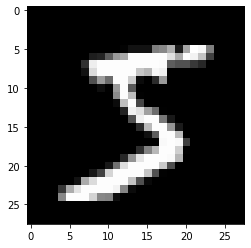

Target = 5


In [6]:
plt.imshow(train_set.data[0], cmap='gray')
plt.show()
print("Target = %i" % train_set.targets[0])

In [7]:
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.seed(seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler)

In [8]:


def train(num_epochs, cnn,train_loader,test_loader):
    epochs = []

    losses = []
    accs = []

    val_losses = []
    val_accs = []
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
           
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)


            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
  
        correct_val = 0
        total_val = 0
        correct = 0
        total = 0
        total_loss = 0
        total_val_loss = 0

        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        print()
        print('Epoch [{}/{}]\n Train Loss: {:.4f}, Train Accuracy: {:.4f}\n Val Loss: {:.4f}, Val Accuracy: {:.4f}' .format(epoch + 1, num_epochs, total_loss, correct/total, total_val_loss, correct_val/total_val ))
        print()
        epochs += [epoch+1]
        losses += [total_loss]
        accs += [correct/total]
        val_losses += [total_val_loss]
        val_accs += [correct_val/total_val]
            
            
    
    
    return (epochs,losses,accs,val_losses,val_accs)


# Activation functions

Relu

In [ ]:
act_func = nn.ReLU()

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.3011
Epoch [1/50], Step [20/53], Loss: 2.2915
Epoch [1/50], Step [30/53], Loss: 2.2722
Epoch [1/50], Step [40/53], Loss: 2.1940
Epoch [1/50], Step [50/53], Loss: 2.1616

Epoch [1/50]
 Train Loss: 113.5280, Train Accuracy: 0.3156
 Val Loss: 12.8907, Val Accuracy: 0.3008

Epoch [2/50], Step [10/53], Loss: 2.1242
Epoch [2/50], Step [20/53], Loss: 2.0907
Epoch [2/50], Step [30/53], Loss: 2.0451
Epoch [2/50], Step [40/53], Loss: 1.9908
Epoch [2/50], Step [50/53], Loss: 1.9472

Epoch [2/50]
 Train Loss: 100.8391, Train Accuracy: 0.5627
 Val Loss: 11.4823, Val Accuracy: 0.5487

Epoch [3/50], Step [10/53], Loss: 1.8310
Epoch [3/50], Step [20/53], Loss: 1.7583
Epoch [3/50], Step [30/53], Loss: 1.7091
Epoch [3/50], Step [40/53], Loss: 1.6397
Epoch [3/50], Step [50/53], Loss: 1.6025

Epoch [3/50]
 Train Loss: 84.4728, Train Accuracy: 0.8861
 Val Loss: 9.5827, Val Accuracy: 0.8810

Epoch [4/50], Step [10/53], Loss: 1.5800
Epoch [4/50], Step [20/53], Loss: 1.5734

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[113.52804708480835, 100.83914172649384, 84.47284054756165, 79.21615195274353, 78.33823323249817, 78.11483716964722, 77.96176755428314, 77.88071072101593, 77.80219316482544, 77.76427054405212, 77.71896481513977, 77.68067038059235, 77.6691222190857, 77.65437018871307, 77.64340996742249, 77.6420247554779, 77.62780177593231, 77.62881433963776, 77.62291860580444, 77.62207460403442, 77.62398147583008, 77.62260901927948, 77.61993157863617, 77.61980056762695, 77.61981725692749, 77.61867380142212, 77.61842465400696, 77.62056636810303, 77.62041974067688, 77.62455022335052, 77.62164556980133, 77.62192356586456, 77.62022960186005, 77.62499594688416, 77.6222927570343, 77.6301851272583, 77.62648701667786, 77.62509143352509, 77.62704753875732, 77.62759852409363, 77.63054919242859, 77.63278293609619, 77.63394367694855, 77.6344301700592, 77.63586342334747, 77.63789868354797, 77.64194023609161, 77.64300644397736, 77.64131498336792, 77.64528143405914]

[0.31557407407407406, 0.5627407407407408, 0.8860925

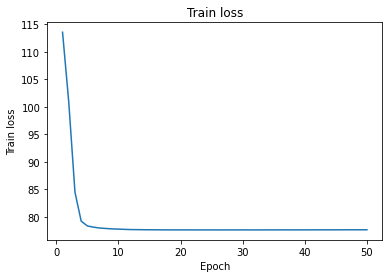

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

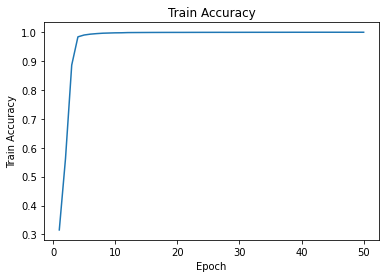

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

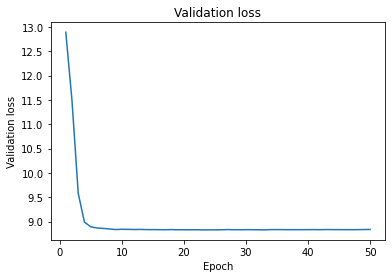

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

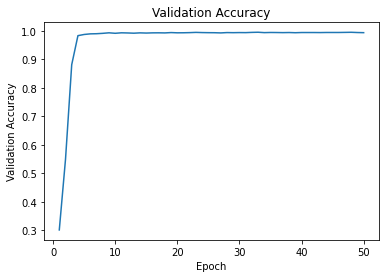

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

val_accs = [0.30083333333333334, 0.5486666666666666, 0.881, 0.9828333333333333, 0.987, 0.9891666666666666, 0.9896666666666667, 0.991, 0.9928333333333333, 0.9911666666666666, 0.9928333333333333, 0.9923333333333333, 0.9915, 0.9926666666666667, 0.992, 0.9926666666666667, 0.9928333333333333, 0.9925, 0.9936666666666667, 0.9928333333333333, 0.993, 0.9935, 0.9943333333333333, 0.9936666666666667, 0.9933333333333333, 0.9931666666666666, 0.9925, 0.9936666666666667, 0.9933333333333333, 0.9936666666666667, 0.9935, 0.9943333333333333, 0.9948333333333333, 0.9935, 0.994, 0.9938333333333333, 0.9935, 0.9938333333333333, 0.9931666666666666, 0.9938333333333333, 0.9938333333333333, 0.9938333333333333, 0.9936666666666667, 0.994, 0.994, 0.994, 0.9943333333333333, 0.9946666666666667, 0.9938333333333333, 0.9933333333333333]
accs = [0.31557407407407406, 0.5627407407407408, 0.8860925925925925, 0.9838703703703704, 0.9901851851851852, 0.9931481481481481, 0.995, 0.9964074074074074, 0.9970555555555556, 0.9977037037037036, 0.9979074074074074, 0.9985555555555555, 0.9987037037037036, 0.9988148148148148, 0.9989259259259259, 0.9990185185185185, 0.9990925925925926, 0.9991481481481481, 0.9991851851851852, 0.9992222222222222, 0.9992222222222222, 0.9992777777777778, 0.9993148148148148, 0.9993703703703704, 0.9993888888888889, 0.9994259259259259, 0.999462962962963, 0.9994444444444445, 0.999462962962963, 0.9995, 0.9995185185185185, 0.9995555555555555, 0.9995740740740741, 0.9995925925925926, 0.9996111111111111, 0.9996296296296296, 0.9996296296296296, 0.9996666666666667, 0.9997037037037036, 0.9997037037037036, 0.9997037037037036, 0.9997407407407407, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592, 0.9997592592592592]
epochs = [i for i in range(1,51)]

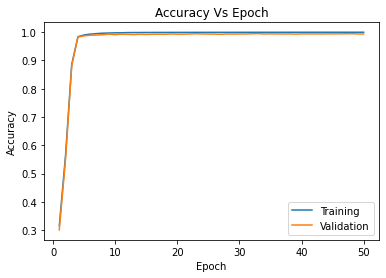

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7187, Test Accuracy: 0.9952


Leaky Relu

In [ ]:
act_func = nn.LeakyReLU(0.1)

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 2.2982
Epoch [1/50], Step [20/53], Loss: 2.2849
Epoch [1/50], Step [30/53], Loss: 2.2264
Epoch [1/50], Step [40/53], Loss: 2.1812
Epoch [1/50], Step [50/53], Loss: 2.1236

Epoch [1/50]
 Train Loss: 110.5770, Train Accuracy: 0.4043
 Val Loss: 12.5652, Val Accuracy: 0.3890

Epoch [2/50], Step [10/53], Loss: 2.0036
Epoch [2/50], Step [20/53], Loss: 1.9469
Epoch [2/50], Step [30/53], Loss: 1.9191
Epoch [2/50], Step [40/53], Loss: 1.8348
Epoch [2/50], Step [50/53], Loss: 1.7513

Epoch [2/50]
 Train Loss: 89.6723, Train Accuracy: 0.9319
 Val Loss: 10.1772, Val Accuracy: 0.9285

Epoch [3/50], Step [10/53], Loss: 1.5771
Epoch [3/50], Step [20/53], Loss: 1.5334
Epoch [3/50], Step [30/53], Loss: 1.5045
Epoch [3/50], Step [40/53], Loss: 1.5010
Epoch [3/50], Step [50/53], Loss: 1.4972

Epoch [3/50]
 Train Loss: 79.0544, Train Accuracy: 0.9821
 Val Loss: 8.9713, Val Accuracy: 0.9768

Epoch [4/50], Step [10/53], Loss: 1.4888
Epoch [4/50], Step [20/53], Loss: 1.4925


In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[110.57701277732849, 89.67226278781891, 79.05443000793457, 78.42666256427765, 78.18000829219818, 78.02697134017944, 77.89865553379059, 77.843212723732, 77.77955520153046, 77.73862946033478, 77.71077036857605, 77.68583011627197, 77.66989469528198, 77.65424108505249, 77.64309060573578, 77.63264083862305, 77.62449538707733, 77.62021386623383, 77.61805307865143, 77.61531126499176, 77.61084353923798, 77.61010277271271, 77.61194062232971, 77.60856544971466, 77.61223316192627, 77.6102659702301, 77.61099207401276, 77.61530208587646, 77.61471974849701, 77.61746311187744, 77.6190482378006, 77.6181173324585, 77.61657166481018, 77.61960315704346, 77.62032639980316, 77.62320041656494, 77.62492525577545, 77.62691831588745, 77.62591540813446, 77.62791693210602, 77.62903964519501, 77.62835431098938, 77.63088202476501, 77.63506174087524, 77.63396632671356, 77.63731241226196, 77.63694894313812, 77.63856709003448, 77.64090359210968, 77.64375758171082]

[0.4042777777777778, 0.9319074074074074, 0.982129629

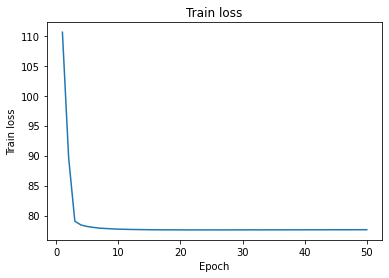

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

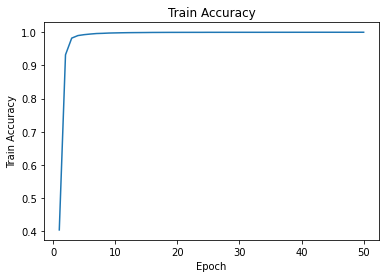

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

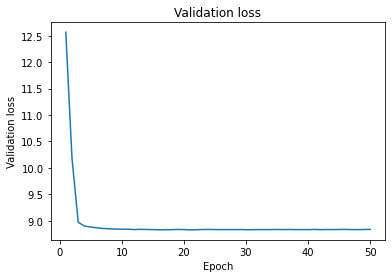

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

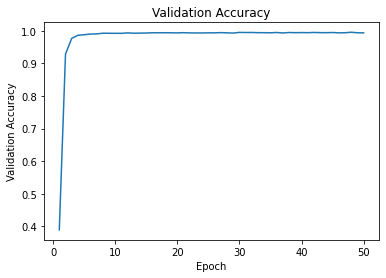

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

val_accs = [0.389, 0.9285, 0.9768333333333333, 0.9861666666666666, 0.9878333333333333, 0.99, 0.9903333333333333, 0.9925, 0.9923333333333333, 0.9921666666666666, 0.9921666666666666, 0.9935, 0.9925, 0.9928333333333333, 0.9931666666666666, 0.9938333333333333, 0.994, 0.994, 0.9938333333333333, 0.9935, 0.9941666666666666, 0.9935, 0.9933333333333333, 0.9933333333333333, 0.9936666666666667, 0.9936666666666667, 0.9943333333333333, 0.9936666666666667, 0.993, 0.995, 0.9946666666666667, 0.9948333333333333, 0.9941666666666666, 0.9941666666666666, 0.9938333333333333, 0.9946666666666667, 0.9933333333333333, 0.9946666666666667, 0.9941666666666666, 0.9945, 0.9941666666666666, 0.9948333333333333, 0.9943333333333333, 0.9941666666666666, 0.9946666666666667, 0.9936666666666667, 0.994, 0.9955, 0.9938333333333333, 0.9936666666666667]
accs = [0.4042777777777778, 0.9319074074074074, 0.9821296296296296, 0.9897962962962963, 0.992537037037037, 0.9944074074074074, 0.9959444444444444, 0.9965555555555555, 0.9973888888888889, 0.9978148148148148, 0.9982037037037037, 0.9985185185185185, 0.9987037037037036, 0.9988333333333334, 0.9989814814814815, 0.9991851851851852, 0.9992592592592593, 0.9993518518518518, 0.9994074074074074, 0.9994259259259259, 0.999462962962963, 0.9994814814814815, 0.9995185185185185, 0.9995185185185185, 0.9995925925925926, 0.9995740740740741, 0.9996111111111111, 0.9996296296296296, 0.9996296296296296, 0.9996296296296296, 0.9996481481481482, 0.9996481481481482, 0.9996481481481482, 0.9996481481481482, 0.9996851851851852, 0.9996851851851852, 0.9996851851851852, 0.9997037037037036, 0.9997407407407407, 0.9997407407407407, 0.9997407407407407, 0.9997777777777778, 0.9997777777777778, 0.9997777777777778, 0.9997777777777778, 0.9997777777777778, 0.9997777777777778, 0.9997777777777778, 0.9997962962962963, 0.9998148148148148]
epochs = [i for i in range(1,51)]

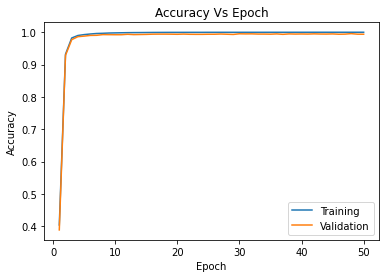

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7198, Test Accuracy: 0.9952


Sigmoid

In [9]:
act_func = nn.Sigmoid()

In [16]:
num_classes = 10
num_epochs = 50
learning_rate = 0.00005
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 2.3022
Epoch [1/50], Step [20/53], Loss: 2.2884
Epoch [1/50], Step [30/53], Loss: 2.2558
Epoch [1/50], Step [40/53], Loss: 2.2028
Epoch [1/50], Step [50/53], Loss: 2.1806

Epoch [1/50]
 Train Loss: 115.9850, Train Accuracy: 0.3127
 Val Loss: 13.1528, Val Accuracy: 0.2983

Epoch [2/50], Step [10/53], Loss: 2.1442
Epoch [2/50], Step [20/53], Loss: 2.1031
Epoch [2/50], Step [30/53], Loss: 2.0447
Epoch [2/50], Step [40/53], Loss: 2.0111
Epoch [2/50], Step [50/53], Loss: 1.9934

Epoch [2/50]
 Train Loss: 104.3624, Train Accuracy: 0.5117
 Val Loss: 11.8733, Val Accuracy: 0.4995

Epoch [3/50], Step [10/53], Loss: 1.9630
Epoch [3/50], Step [20/53], Loss: 1.9212
Epoch [3/50], Step [30/53], Loss: 1.9002
Epoch [3/50], Step [40/53], Loss: 1.8768
Epoch [3/50], Step [50/53], Loss: 1.8184

Epoch [3/50]
 Train Loss: 95.8721, Train Accuracy: 0.7006
 Val Loss: 10.9157, Val Accuracy: 0.6867

Epoch [4/50], Step [10/53], Loss: 1.8105
Epoch [4/50], Step [20/53], Loss: 1.770

In [18]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[115.9850172996521, 104.36241161823273, 95.87206089496613, 90.18012571334839, 87.07856380939484, 84.06647968292236, 83.55723226070404, 83.10281920433044, 83.04889452457428, 82.96119475364685, 82.75715672969818, 82.97812926769257, 82.55291140079498, 82.53385031223297, 82.54025340080261, 82.39879655838013, 82.44009351730347, 82.42471706867218, 82.52732753753662, 82.52478098869324, 82.37358379364014, 82.31225454807281, 82.32911264896393, 82.29164361953735, 82.44317209720612, 82.37706458568573, 82.33958292007446, 82.26939082145691, 82.28227055072784, 82.33159530162811, 82.2318354845047, 82.23836433887482, 82.22263300418854, 82.22096264362335, 82.17965841293335, 82.21221041679382, 82.19487082958221, 82.18352842330933, 82.20182275772095, 82.17081427574158, 82.22806894779205, 82.1306084394455, 82.15875792503357, 82.21032917499542, 82.21347439289093, 82.24893009662628, 82.13422429561615, 77.92499303817749, 77.75500285625458, 77.67326271533966]

[0.31272222222222223, 0.5116666666666667, 0.70061

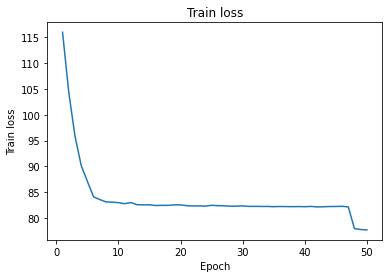

In [19]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

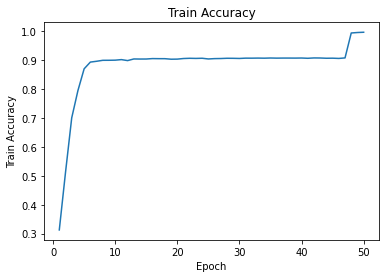

In [20]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

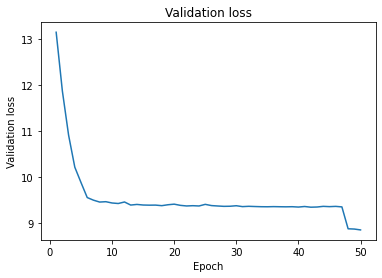

In [21]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

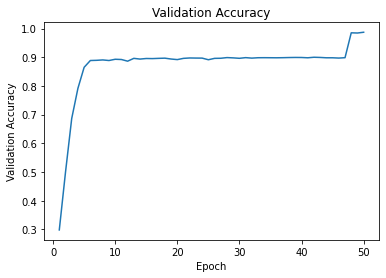

In [22]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
accs = [0.31272222222222223, 0.5116666666666667, 0.7006111111111111, 0.7951851851851852, 0.8705, 0.8937407407407407, 0.8965555555555556, 0.8999074074074074, 0.9000185185185186, 0.9004074074074074, 0.9022962962962963, 0.8989259259259259, 0.9045740740740741, 0.9042962962962963, 0.9043888888888889, 0.9058518518518518, 0.9055740740740741, 0.9055555555555556, 0.9037407407407407, 0.9040370370370371, 0.9061296296296296, 0.9069074074074074, 0.9064629629629629, 0.907, 0.9045925925925926, 0.9057777777777778, 0.9061111111111111, 0.906962962962963, 0.9068148148148149, 0.9063518518518519, 0.9073703703703704, 0.9072962962962963, 0.9075925925925926, 0.9072592592592592, 0.9078703703703703, 0.907425925925926, 0.9076481481481481, 0.9076666666666666, 0.907537037037037, 0.9078333333333334, 0.9069074074074074, 0.9081111111111111, 0.9078888888888889, 0.9070185185185186, 0.9072592592592592, 0.906425925925926, 0.9081851851851852, 0.9945, 0.9961296296296296, 0.9970740740740741]
val_accs =[0.29833333333333334, 0.4995, 0.6866666666666666, 0.7918333333333333, 0.865, 0.8886666666666667, 0.8893333333333333, 0.8906666666666667, 0.8886666666666667, 0.893, 0.8921666666666667, 0.8863333333333333, 0.8961666666666667, 0.8936666666666667, 0.8956666666666667, 0.8953333333333333, 0.8961666666666667, 0.8968333333333334, 0.8938333333333334, 0.8918333333333334, 0.8961666666666667, 0.8975, 0.8971666666666667, 0.897, 0.8913333333333333, 0.8961666666666667, 0.8965, 0.8988333333333334, 0.8978333333333334, 0.8963333333333333, 0.8986666666666666, 0.897, 0.8983333333333333, 0.8985, 0.8983333333333333, 0.8981666666666667, 0.8985, 0.899, 0.8993333333333333, 0.8991666666666667, 0.8981666666666667, 0.9, 0.8993333333333333, 0.8981666666666667, 0.8981666666666667, 0.8971666666666667, 0.8985, 0.9851666666666666, 0.9845, 0.9871666666666666] 
epochs = [i for i in range(1,51)]

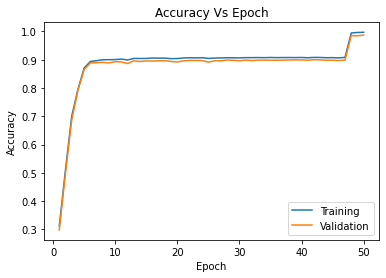

In [24]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [25]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7630, Test Accuracy: 0.9864


Tanh

In [ ]:
act_func = nn.Tanh()

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 2.2979
Epoch [1/50], Step [20/53], Loss: 2.2869
Epoch [1/50], Step [30/53], Loss: 2.2539
Epoch [1/50], Step [40/53], Loss: 2.2210
Epoch [1/50], Step [50/53], Loss: 2.1613

Epoch [1/50]
 Train Loss: 112.4208, Train Accuracy: 0.4469
 Val Loss: 12.7485, Val Accuracy: 0.4353

Epoch [2/50], Step [10/53], Loss: 2.0567
Epoch [2/50], Step [20/53], Loss: 1.9457
Epoch [2/50], Step [30/53], Loss: 1.8436
Epoch [2/50], Step [40/53], Loss: 1.7769
Epoch [2/50], Step [50/53], Loss: 1.7041

Epoch [2/50]
 Train Loss: 88.6211, Train Accuracy: 0.8602
 Val Loss: 10.0651, Val Accuracy: 0.8557

Epoch [3/50], Step [10/53], Loss: 1.6238
Epoch [3/50], Step [20/53], Loss: 1.5945
Epoch [3/50], Step [30/53], Loss: 1.5536
Epoch [3/50], Step [40/53], Loss: 1.5260
Epoch [3/50], Step [50/53], Loss: 1.5124

Epoch [3/50]
 Train Loss: 79.6403, Train Accuracy: 0.9787
 Val Loss: 9.0479, Val Accuracy: 0.9747

Epoch [4/50], Step [10/53], Loss: 1.4975
Epoch [4/50], Step [20/53], Loss: 1.4903


In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[112.42077159881592, 88.62112390995026, 79.64029717445374, 78.6812926530838, 78.30464839935303, 78.0989077091217, 77.93373155593872, 77.87312304973602, 77.81353807449341, 77.77795231342316, 77.74252653121948, 77.7182879447937, 77.70732295513153, 77.69037210941315, 77.6851441860199, 77.67813992500305, 77.67923152446747, 77.66838526725769, 77.66439926624298, 77.66355204582214, 77.6592047214508, 77.66087234020233, 77.65922200679779, 77.6618869304657, 77.66195285320282, 77.65856969356537, 77.65861809253693, 77.65814852714539, 77.66012108325958, 77.66230487823486, 77.66173899173737, 77.66194927692413, 77.65785527229309, 77.67029118537903, 77.65839993953705, 77.65934348106384, 77.6629114151001, 77.6591008901596, 77.66345357894897, 77.66306781768799, 77.66965544223785, 77.66935217380524, 77.66429209709167, 77.66953122615814, 77.67596471309662, 77.66905927658081, 77.68185460567474, 77.67560470104218, 77.68061220645905, 77.67769181728363]

[0.4468888888888889, 0.8601666666666666, 0.978722222222

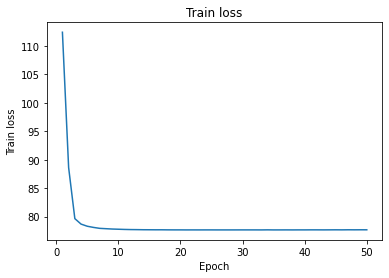

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

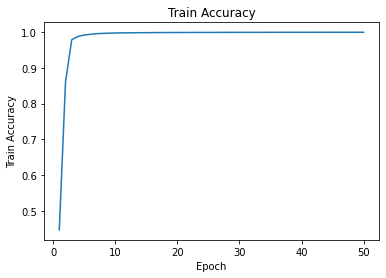

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

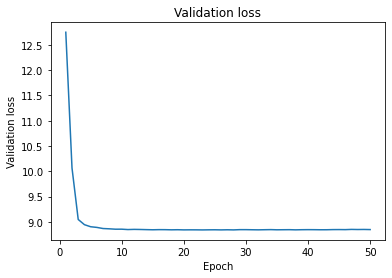

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

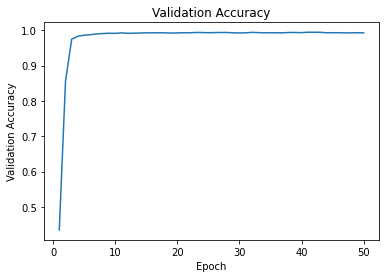

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs = [0.4468888888888889, 0.8601666666666666, 0.9787222222222223, 0.9877777777777778, 0.9918148148148148, 0.9939074074074075, 0.9957592592592592, 0.9963703703703704, 0.9970925925925926, 0.9975555555555555, 0.9978888888888889, 0.9980370370370371, 0.9981666666666666, 0.9983703703703704, 0.9985, 0.9987037037037036, 0.9987962962962963, 0.9988518518518519, 0.9989259259259259, 0.9989444444444444, 0.9989814814814815, 0.999, 0.9990555555555556, 0.9990740740740741, 0.9991296296296296, 0.9991851851851852, 0.9992592592592593, 0.9993333333333333, 0.9993333333333333, 0.9993518518518518, 0.9993888888888889, 0.9993703703703704, 0.9993888888888889, 0.9994074074074074, 0.9994259259259259, 0.9995185185185185, 0.9995185185185185, 0.999537037037037, 0.999537037037037, 0.999537037037037, 0.9995555555555555, 0.9995740740740741, 0.9995740740740741, 0.9995925925925926, 0.9996111111111111, 0.9996111111111111, 0.9996111111111111, 0.9996111111111111, 0.9996296296296296, 0.9996666666666667]
val_accs = [0.43533333333333335, 0.8556666666666667, 0.9746666666666667, 0.9826666666666667, 0.9856666666666667, 0.987, 0.9891666666666666, 0.9903333333333333, 0.9911666666666666, 0.9908333333333333, 0.9921666666666666, 0.991, 0.9913333333333333, 0.9918333333333333, 0.9923333333333333, 0.9923333333333333, 0.9925, 0.9923333333333333, 0.9916666666666667, 0.9921666666666666, 0.9925, 0.9925, 0.9933333333333333, 0.9931666666666666, 0.9926666666666667, 0.993, 0.9933333333333333, 0.9933333333333333, 0.9923333333333333, 0.992, 0.9923333333333333, 0.9936666666666667, 0.993, 0.9923333333333333, 0.9926666666666667, 0.9925, 0.9923333333333333, 0.9933333333333333, 0.9933333333333333, 0.9928333333333333, 0.994, 0.994, 0.9938333333333333, 0.9925, 0.9926666666666667, 0.9926666666666667, 0.9921666666666666, 0.9923333333333333, 0.9926666666666667, 0.9921666666666666]
epochs = [i for i in range(1,51)]

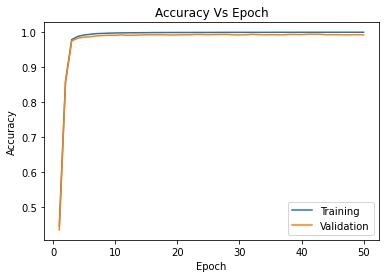

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7454, Test Accuracy: 0.9930


# Learning rate

0.001

In [ ]:
learning_rate = 0.001

In [ ]:
num_classes = 10
num_epochs = 50
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.3024
Epoch [1/50], Step [20/53], Loss: 2.3024
Epoch [1/50], Step [30/53], Loss: 2.3013
Epoch [1/50], Step [40/53], Loss: 2.3019
Epoch [1/50], Step [50/53], Loss: 2.3022

Epoch [1/50]
 Train Loss: 121.9897, Train Accuracy: 0.1151
 Val Loss: 13.8153, Val Accuracy: 0.1130

Epoch [2/50], Step [10/53], Loss: 2.3016
Epoch [2/50], Step [20/53], Loss: 2.3008
Epoch [2/50], Step [30/53], Loss: 2.3008
Epoch [2/50], Step [40/53], Loss: 2.2996
Epoch [2/50], Step [50/53], Loss: 2.3006

Epoch [2/50]
 Train Loss: 121.9324, Train Accuracy: 0.1248
 Val Loss: 13.8067, Val Accuracy: 0.1220

Epoch [3/50], Step [10/53], Loss: 2.3004
Epoch [3/50], Step [20/53], Loss: 2.2997
Epoch [3/50], Step [30/53], Loss: 2.2995
Epoch [3/50], Step [40/53], Loss: 2.2999
Epoch [3/50], Step [50/53], Loss: 2.2986

Epoch [3/50]
 Train Loss: 121.8689, Train Accuracy: 0.1407
 Val Loss: 13.7991, Val Accuracy: 0.1380

Epoch [4/50], Step [10/53], Loss: 2.2986
Epoch [4/50], Step [20/53], Loss: 2.29

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[121.98972964286804, 121.93237090110779, 121.86890959739685, 121.79743123054504, 121.72657251358032, 121.63838768005371, 121.52782392501831, 121.37941360473633, 121.1763744354248, 120.82347178459167, 120.1879301071167, 119.38495016098022, 118.76824736595154, 118.2985315322876, 117.90381979942322, 117.5784637928009, 117.23418641090393, 116.87219619750977, 116.4560775756836, 116.00053262710571, 115.54339051246643, 115.09181332588196, 114.6609845161438, 114.27201533317566, 113.8477110862732, 113.40713047981262, 112.90164709091187, 112.29802918434143, 111.58204317092896, 110.8235535621643, 110.02730298042297, 109.24402332305908, 108.57170486450195, 108.02213168144226, 107.54585123062134, 107.14270627498627, 106.82204151153564, 106.50294578075409, 106.24653208255768, 105.99388229846954, 105.77469682693481, 105.53422498703003, 105.32761836051941, 105.1272337436676, 104.9375569820404, 104.71819221973419, 104.50852429866791, 104.30211865901947, 104.06725358963013, 103.79519641399384]

[0.11509

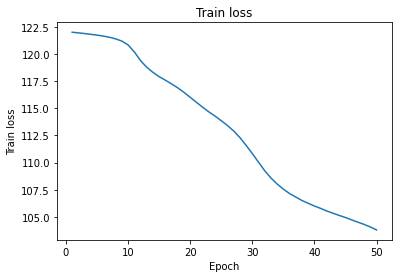

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

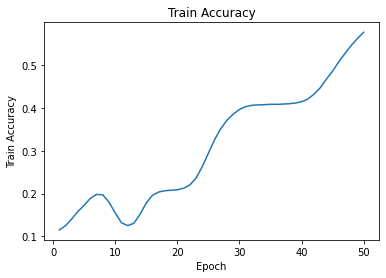

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

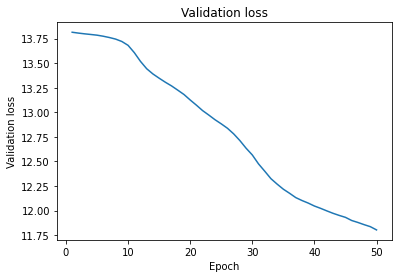

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

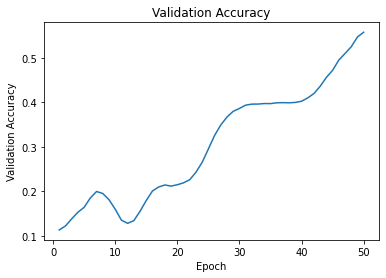

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.1150925925925926, 0.1247962962962963, 0.1407037037037037, 0.15833333333333333, 0.1723888888888889, 0.1889074074074074, 0.19807407407407407, 0.197, 0.1799814814814815, 0.15503703703703703, 0.13192592592592592, 0.12518518518518518, 0.13048148148148148, 0.1514814814814815, 0.17803703703703705, 0.19598148148148148, 0.2036111111111111, 0.2066111111111111, 0.20783333333333334, 0.20879629629629629, 0.21246296296296296, 0.22, 0.23564814814814813, 0.2625, 0.2941111111111111, 0.32587037037037037, 0.3516851851851852, 0.3715, 0.3856111111111111, 0.39631481481481484, 0.4031666666666667, 0.4061296296296296, 0.4070925925925926, 0.4075740740740741, 0.40853703703703703, 0.4084074074074074, 0.4090740740740741, 0.4098148148148148, 0.4114814814814815, 0.41455555555555557, 0.42064814814814816, 0.4320925925925926, 0.4469814814814815, 0.46725925925925926, 0.48588888888888887, 0.5079814814814815, 0.527425925925926, 0.545962962962963, 0.5621666666666667, 0.5768333333333333]
val_accs = [0.113, 0.122, 0.138, 0.15283333333333332, 0.16383333333333333, 0.185, 0.1995, 0.195, 0.181, 0.15966666666666668, 0.135, 0.12783333333333333, 0.13383333333333333, 0.155, 0.17916666666666667, 0.20066666666666666, 0.20966666666666667, 0.21416666666666667, 0.21166666666666667, 0.21466666666666667, 0.219, 0.226, 0.24283333333333335, 0.26516666666666666, 0.2951666666666667, 0.32566666666666666, 0.34933333333333333, 0.36716666666666664, 0.38, 0.3865, 0.3938333333333333, 0.39616666666666667, 0.3963333333333333, 0.3975, 0.3973333333333333, 0.39916666666666667, 0.3995, 0.39916666666666667, 0.4, 0.4026666666666667, 0.4101666666666667, 0.4201666666666667, 0.43633333333333335, 0.4563333333333333, 0.4723333333333333, 0.49533333333333335, 0.5101666666666667, 0.5253333333333333, 0.5473333333333333, 0.558]
epochs = [i for i in range(1,51)]

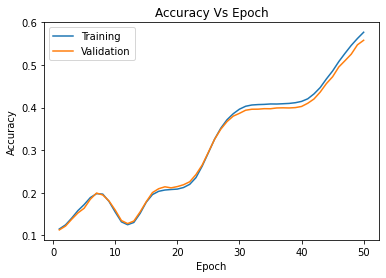

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 19.6174, Test Accuracy: 0.5704


0.005

In [ ]:
learning_rate = 0.005

In [ ]:
num_classes = 10
num_epochs = 50
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 2.3020
Epoch [1/50], Step [20/53], Loss: 2.2997
Epoch [1/50], Step [30/53], Loss: 2.3006
Epoch [1/50], Step [40/53], Loss: 2.3006
Epoch [1/50], Step [50/53], Loss: 2.2986

Epoch [1/50]
 Train Loss: 121.7776, Train Accuracy: 0.1274
 Val Loss: 13.7880, Val Accuracy: 0.1258

Epoch [2/50], Step [10/53], Loss: 2.2971
Epoch [2/50], Step [20/53], Loss: 2.2958
Epoch [2/50], Step [30/53], Loss: 2.2940
Epoch [2/50], Step [40/53], Loss: 2.2923
Epoch [2/50], Step [50/53], Loss: 2.2920

Epoch [2/50]
 Train Loss: 121.4069, Train Accuracy: 0.1832
 Val Loss: 13.7450, Val Accuracy: 0.1815

Epoch [3/50], Step [10/53], Loss: 2.2910
Epoch [3/50], Step [20/53], Loss: 2.2847
Epoch [3/50], Step [30/53], Loss: 2.2816
Epoch [3/50], Step [40/53], Loss: 2.2812
Epoch [3/50], Step [50/53], Loss: 2.2779

Epoch [3/50]
 Train Loss: 120.4266, Train Accuracy: 0.2468
 Val Loss: 13.6402, Val Accuracy: 0.2437

Epoch [4/50], Step [10/53], Loss: 2.2608
Epoch [4/50], Step [20/53], Loss: 2.25

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[121.77761054039001, 121.4069185256958, 120.42656230926514, 116.6849946975708, 114.00229096412659, 111.35280752182007, 109.77109837532043, 107.46244430541992, 105.07794106006622, 101.88040840625763, 99.23958909511566, 97.68453657627106, 96.43640875816345, 94.79470181465149, 92.37214779853821, 89.74903786182404, 87.31481719017029, 84.28299152851105, 82.11095118522644, 80.99824464321136, 80.33360183238983, 79.93538761138916, 79.62427484989166, 79.39210665225983, 79.23171520233154, 79.05950629711151, 78.94578492641449, 78.82291448116302, 78.75467443466187, 78.6707501411438, 78.58994221687317, 78.5217056274414, 78.46905422210693, 78.42205023765564, 78.3826869726181, 78.31545186042786, 78.27565324306488, 78.24724066257477, 78.21897876262665, 78.19461071491241, 78.14740979671478, 78.12065589427948, 78.10091376304626, 78.06992197036743, 78.04905843734741, 78.03881931304932, 78.01894927024841, 77.98724031448364, 77.9610515832901, 77.95483613014221]

[0.12742592592592591, 0.18318518518518517, 0

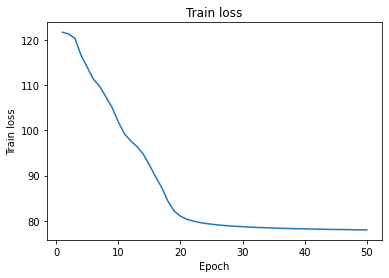

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

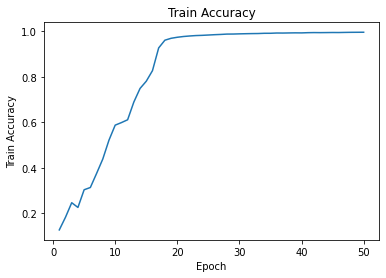

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

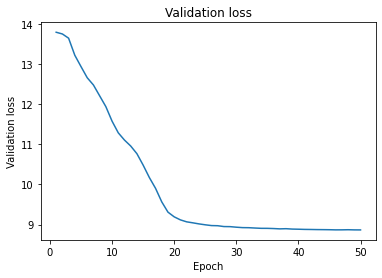

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

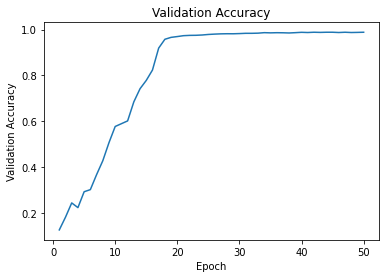

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.12742592592592591, 0.18318518518518517, 0.2467777777777778, 0.22605555555555557, 0.30366666666666664, 0.3136111111111111, 0.37501851851851853, 0.43833333333333335, 0.5215, 0.5872592592592593, 0.5983703703703703, 0.6108148148148148, 0.6885370370370371, 0.7482407407407408, 0.7799259259259259, 0.8262962962962963, 0.9262222222222222, 0.9600185185185185, 0.9684074074074074, 0.972925925925926, 0.9762592592592593, 0.9785555555555555, 0.9803703703703703, 0.9813333333333333, 0.9827407407407407, 0.9842037037037037, 0.9853333333333333, 0.9868703703703704, 0.9870555555555556, 0.9878888888888889, 0.9884814814814815, 0.989, 0.9893148148148149, 0.9903148148148149, 0.9904074074074074, 0.9915555555555555, 0.9913888888888889, 0.9919074074074075, 0.9922962962962963, 0.9920740740740741, 0.9930185185185185, 0.993462962962963, 0.9932407407407408, 0.9935, 0.9937962962962963, 0.9937037037037038, 0.9942222222222222, 0.9946111111111111, 0.9947962962962963, 0.9949444444444444]
val_accs = [0.12583333333333332, 0.1815, 0.24366666666666667, 0.22316666666666668, 0.2925, 0.3016666666666667, 0.36683333333333334, 0.4275, 0.5068333333333334, 0.5773333333333334, 0.5895, 0.6016666666666667, 0.6848333333333333, 0.7421666666666666, 0.7783333333333333, 0.8236666666666667, 0.9195, 0.958, 0.9663333333333334, 0.9698333333333333, 0.9736666666666667, 0.975, 0.9753333333333334, 0.9766666666666667, 0.979, 0.9805, 0.9816666666666667, 0.9821666666666666, 0.982, 0.9828333333333333, 0.984, 0.984, 0.9846666666666667, 0.9868333333333333, 0.986, 0.9866666666666667, 0.9863333333333333, 0.9855, 0.9868333333333333, 0.9883333333333333, 0.9875, 0.9886666666666667, 0.988, 0.9886666666666667, 0.9886666666666667, 0.9875, 0.9886666666666667, 0.9875, 0.988, 0.9886666666666667]
epochs = [i for i in range(1,51)]

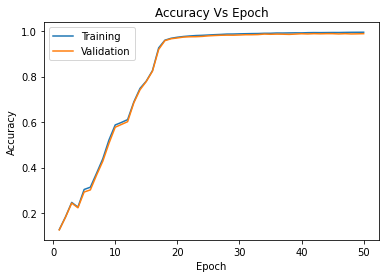

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7595, Test Accuracy: 0.9899


0.01

In [ ]:
learning_rate = 0.01

In [ ]:
num_classes = 10
num_epochs = 50
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 2.3025
Epoch [1/50], Step [20/53], Loss: 2.3015
Epoch [1/50], Step [30/53], Loss: 2.2984
Epoch [1/50], Step [40/53], Loss: 2.2961
Epoch [1/50], Step [50/53], Loss: 2.2915

Epoch [1/50]
 Train Loss: 121.4115, Train Accuracy: 0.1653
 Val Loss: 13.7544, Val Accuracy: 0.1555

Epoch [2/50], Step [10/53], Loss: 2.2818
Epoch [2/50], Step [20/53], Loss: 2.2778
Epoch [2/50], Step [30/53], Loss: 2.2347
Epoch [2/50], Step [40/53], Loss: 2.2075
Epoch [2/50], Step [50/53], Loss: 2.1841

Epoch [2/50]
 Train Loss: 115.6437, Train Accuracy: 0.2104
 Val Loss: 13.1304, Val Accuracy: 0.2028

Epoch [3/50], Step [10/53], Loss: 2.1731
Epoch [3/50], Step [20/53], Loss: 2.1549
Epoch [3/50], Step [30/53], Loss: 2.1443
Epoch [3/50], Step [40/53], Loss: 2.1451
Epoch [3/50], Step [50/53], Loss: 2.1392

Epoch [3/50]
 Train Loss: 113.6052, Train Accuracy: 0.2565
 Val Loss: 12.9034, Val Accuracy: 0.2477

Epoch [4/50], Step [10/53], Loss: 2.1407
Epoch [4/50], Step [20/53], Loss: 2.13

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[121.41152000427246, 115.64365768432617, 113.6052041053772, 111.16110610961914, 106.27072846889496, 102.9846693277359, 98.29389977455139, 93.65669107437134, 87.8415402173996, 85.01884973049164, 83.34691047668457, 80.69598376750946, 79.66517436504364, 79.18478620052338, 78.90422201156616, 78.70759677886963, 78.54700195789337, 78.43792355060577, 78.33431780338287, 78.24396467208862, 78.17601191997528, 78.11801087856293, 78.06438887119293, 78.02139115333557, 77.98891198635101, 77.94910418987274, 77.91083300113678, 77.88064873218536, 77.8510262966156, 77.82875859737396, 77.80218207836151, 77.78649735450745, 77.7705135345459, 77.75313067436218, 77.73277759552002, 77.71450710296631, 77.70534062385559, 77.69489097595215, 77.68956410884857, 77.68077409267426, 77.66059625148773, 77.65296828746796, 77.63968825340271, 77.6360992193222, 77.62709879875183, 77.62190878391266, 77.61966586112976, 77.61033093929291, 77.6074846982956, 77.60286915302277]

[0.16527777777777777, 0.2104074074074074, 0.25651

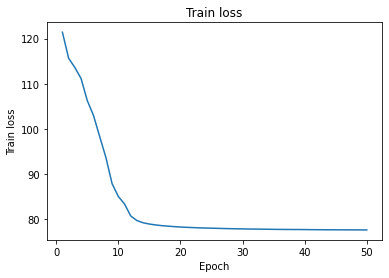

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

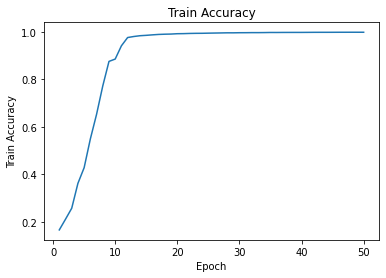

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

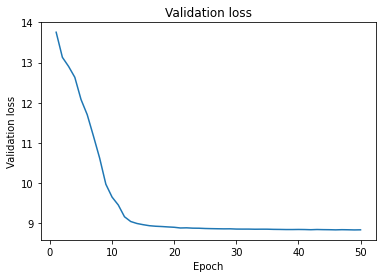

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

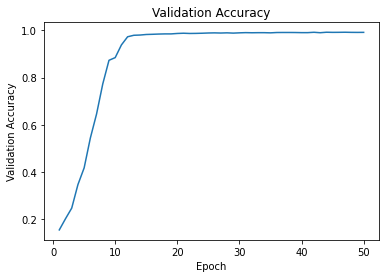

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.16527777777777777, 0.2104074074074074, 0.25651851851851853, 0.3616666666666667, 0.4275555555555556, 0.5487777777777778, 0.6524444444444445, 0.7721666666666667, 0.8755925925925926, 0.885425925925926, 0.9412592592592592, 0.9761481481481481, 0.9805185185185186, 0.9838148148148148, 0.9854444444444445, 0.9874814814814815, 0.9892407407407408, 0.9902037037037037, 0.9908518518518519, 0.9922592592592593, 0.9926296296296296, 0.9934074074074074, 0.9938703703703704, 0.994037037037037, 0.9945925925925926, 0.9950740740740741, 0.9955185185185185, 0.9960555555555556, 0.996, 0.996462962962963, 0.9965555555555555, 0.9968518518518519, 0.9968333333333333, 0.9970925925925926, 0.9975, 0.9974444444444445, 0.9976481481481482, 0.9977037037037036, 0.9977592592592592, 0.9977777777777778, 0.9979444444444444, 0.9981296296296296, 0.9981851851851852, 0.9981851851851852, 0.9982592592592593, 0.9983888888888889, 0.9984074074074074, 0.998462962962963, 0.9984444444444445, 0.9984074074074074]
val_accs = [0.1555, 0.20283333333333334, 0.24766666666666667, 0.3471666666666667, 0.41783333333333333, 0.5441666666666667, 0.6458333333333334, 0.7731666666666667, 0.873, 0.8843333333333333, 0.938, 0.9725, 0.9788333333333333, 0.9798333333333333, 0.9821666666666666, 0.983, 0.984, 0.9846666666666667, 0.9846666666666667, 0.9865, 0.9875, 0.9865, 0.9868333333333333, 0.9875, 0.9885, 0.989, 0.9883333333333333, 0.9891666666666666, 0.988, 0.9891666666666666, 0.99, 0.9895, 0.9898333333333333, 0.9898333333333333, 0.9891666666666666, 0.9905, 0.9906666666666667, 0.9906666666666667, 0.9905, 0.99, 0.99, 0.9915, 0.9896666666666667, 0.9916666666666667, 0.9911666666666666, 0.9913333333333333, 0.9916666666666667, 0.9911666666666666, 0.991, 0.9911666666666666]
epochs = [i for i in range(1,51)]

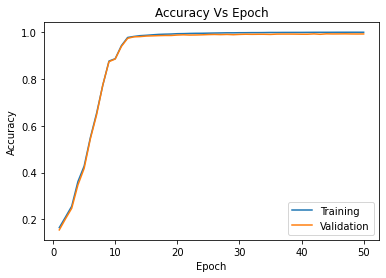

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7147, Test Accuracy: 0.9919


# Optimizer

Vanilla Gradient Descent

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 0.01
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.3016
Epoch [1/50], Step [20/53], Loss: 2.2993
Epoch [1/50], Step [30/53], Loss: 2.2971
Epoch [1/50], Step [40/53], Loss: 2.2956
Epoch [1/50], Step [50/53], Loss: 2.2923

Epoch [1/50]
 Train Loss: 121.4317, Train Accuracy: 0.2224
 Val Loss: 13.7472, Val Accuracy: 0.2270

Epoch [2/50], Step [10/53], Loss: 2.2854
Epoch [2/50], Step [20/53], Loss: 2.2719
Epoch [2/50], Step [30/53], Loss: 2.2468
Epoch [2/50], Step [40/53], Loss: 2.2146
Epoch [2/50], Step [50/53], Loss: 2.2169

Epoch [2/50]
 Train Loss: 117.1407, Train Accuracy: 0.2106
 Val Loss: 13.2667, Val Accuracy: 0.2007

Epoch [3/50], Step [10/53], Loss: 2.1823
Epoch [3/50], Step [20/53], Loss: 2.1750
Epoch [3/50], Step [30/53], Loss: 2.1576
Epoch [3/50], Step [40/53], Loss: 2.1719
Epoch [3/50], Step [50/53], Loss: 2.1627

Epoch [3/50]
 Train Loss: 113.7010, Train Accuracy: 0.2553
 Val Loss: 12.9077, Val Accuracy: 0.2455

Epoch [4/50], Step [10/53], Loss: 2.1378
Epoch [4/50], Step [20/53], Loss: 2.14

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[121.43169116973877, 117.14074230194092, 113.70101737976074, 110.7543625831604, 103.13956618309021, 97.6039754152298, 92.56566548347473, 88.08401787281036, 85.15636110305786, 83.62521314620972, 81.10855412483215, 79.73657858371735, 79.21660912036896, 78.92439186573029, 78.72175717353821, 78.57407701015472, 78.45582985877991, 78.37519085407257, 78.28361332416534, 78.21069657802582, 78.16554403305054, 78.10741579532623, 78.06258833408356, 78.0069432258606, 77.96458041667938, 77.93168866634369, 77.91819906234741, 77.88030993938446, 77.8656941652298, 77.83577835559845, 77.81399857997894, 77.78464734554291, 77.77140951156616, 77.75490915775299, 77.74153196811676, 77.72253739833832, 77.7106944322586, 77.69799268245697, 77.6792676448822, 77.67438328266144, 77.66149985790253, 77.65270054340363, 77.63872921466827, 77.63295531272888, 77.62689709663391, 77.61827385425568, 77.61827743053436, 77.60929203033447, 77.60356199741364, 77.60060441493988]

[0.22242592592592592, 0.21057407407407408, 0.2552

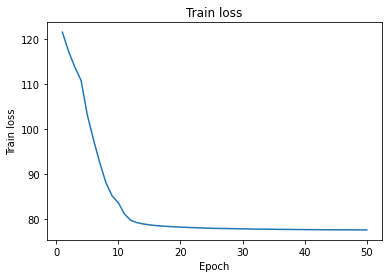

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

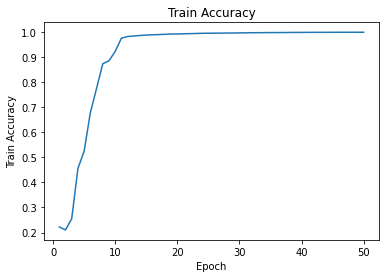

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

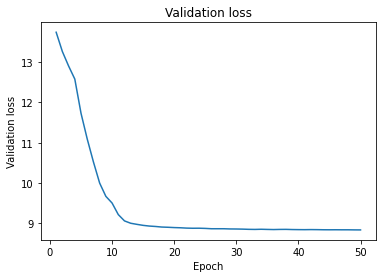

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

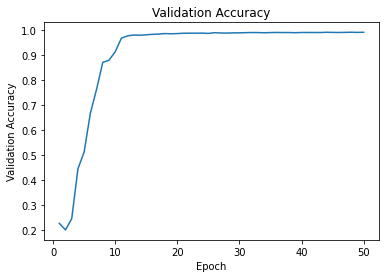

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.22242592592592592, 0.21057407407407408, 0.2552962962962963, 0.4554814814814815, 0.5245555555555556, 0.678074074074074, 0.7746851851851851, 0.8728888888888889, 0.8848518518518519, 0.9222037037037037, 0.9747407407407407, 0.9814259259259259, 0.9837037037037037, 0.985574074074074, 0.9873518518518518, 0.9883703703703703, 0.9892962962962963, 0.9902962962962963, 0.9915, 0.9918148148148148, 0.9924814814814815, 0.9929444444444444, 0.9936296296296296, 0.9943148148148148, 0.9945555555555555, 0.9950185185185185, 0.9949814814814815, 0.9954444444444445, 0.995537037037037, 0.9959629629629629, 0.9962407407407408, 0.9966481481481482, 0.9967407407407407, 0.9969814814814815, 0.9972592592592593, 0.9972592592592593, 0.9974074074074074, 0.9976111111111111, 0.9978888888888889, 0.9978888888888889, 0.9980925925925926, 0.9981296296296296, 0.9982222222222222, 0.9982037037037037, 0.9983148148148148, 0.9985185185185185, 0.998462962962963, 0.9985185185185185, 0.9985555555555555, 0.9984814814814815]
val_accs = [0.227, 0.20066666666666666, 0.2455, 0.44516666666666665, 0.5126666666666667, 0.6678333333333333, 0.7633333333333333, 0.8715, 0.88, 0.914, 0.9685, 0.9778333333333333, 0.981, 0.9801666666666666, 0.982, 0.9838333333333333, 0.9848333333333333, 0.9868333333333333, 0.986, 0.9868333333333333, 0.9881666666666666, 0.9885, 0.9883333333333333, 0.9886666666666667, 0.9875, 0.9903333333333333, 0.9891666666666666, 0.9888333333333333, 0.9896666666666667, 0.9898333333333333, 0.9905, 0.991, 0.9908333333333333, 0.9901666666666666, 0.9908333333333333, 0.9913333333333333, 0.991, 0.991, 0.9903333333333333, 0.9911666666666666, 0.9911666666666666, 0.9911666666666666, 0.991, 0.992, 0.9915, 0.9911666666666666, 0.9916666666666667, 0.9921666666666666, 0.9915, 0.992]
epochs = [i for i in range(1,51)]

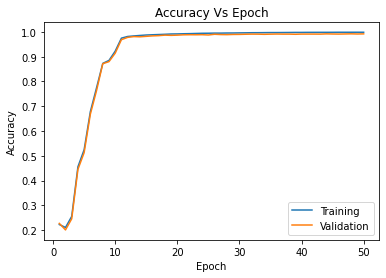

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.7136, Test Accuracy: 0.9919


Momentum-based Gradient Descent

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 0.01
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)

In [ ]:
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.2972
Epoch [1/50], Step [20/53], Loss: 2.2613
Epoch [1/50], Step [30/53], Loss: 2.1821
Epoch [1/50], Step [40/53], Loss: 2.1132
Epoch [1/50], Step [50/53], Loss: 2.0363

Epoch [1/50]
 Train Loss: 106.7128, Train Accuracy: 0.4963
 Val Loss: 12.1374, Val Accuracy: 0.4842

Epoch [2/50], Step [10/53], Loss: 1.9127
Epoch [2/50], Step [20/53], Loss: 1.8207
Epoch [2/50], Step [30/53], Loss: 1.6803
Epoch [2/50], Step [40/53], Loss: 1.5764
Epoch [2/50], Step [50/53], Loss: 1.5755

Epoch [2/50]
 Train Loss: 83.5712, Train Accuracy: 0.8892
 Val Loss: 9.4782, Val Accuracy: 0.8855

Epoch [3/50], Step [10/53], Loss: 1.5656
Epoch [3/50], Step [20/53], Loss: 1.5534
Epoch [3/50], Step [30/53], Loss: 1.5457
Epoch [3/50], Step [40/53], Loss: 1.5058
Epoch [3/50], Step [50/53], Loss: 1.4792

Epoch [3/50]
 Train Loss: 78.5579, Train Accuracy: 0.9864
 Val Loss: 8.9189, Val Accuracy: 0.9837

Epoch [4/50], Step [10/53], Loss: 1.4798
Epoch [4/50], Step [20/53], Loss: 1.4756
E

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[106.71275007724762, 83.57115769386292, 78.55794703960419, 78.0200914144516, 77.85810554027557, 77.72828376293182, 77.66513180732727, 77.59689164161682, 77.57978940010071, 77.53552663326263, 77.52258956432343, 77.5154402256012, 77.50703346729279, 77.4991604089737, 77.49446737766266, 77.49285864830017, 77.48612749576569, 77.48239862918854, 77.48165893554688, 77.47942650318146, 77.47813260555267, 77.4754444360733, 77.47450840473175, 77.47401475906372, 77.47161877155304, 77.47196853160858, 77.47083902359009, 77.47022128105164, 77.47011888027191, 77.46936285495758, 77.46824443340302, 77.46876335144043, 77.46812152862549, 77.46672940254211, 77.46589660644531, 77.46662497520447, 77.46633243560791, 77.46606242656708, 77.4659663438797, 77.46638929843903, 77.46542775630951, 77.46523368358612, 77.46475923061371, 77.46385622024536, 77.46323215961456, 77.46380198001862, 77.4628369808197, 77.46386981010437, 77.46276438236237, 77.46290230751038]

[0.49625925925925923, 0.8892222222222222, 0.986425925

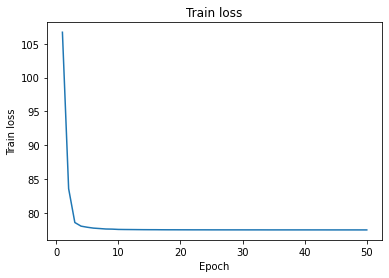

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

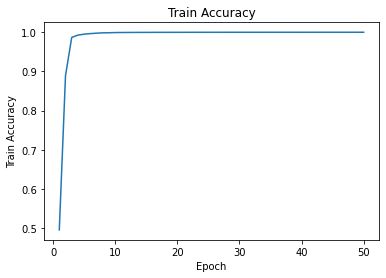

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

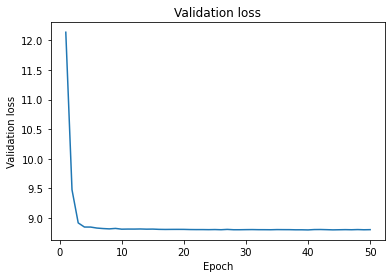

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

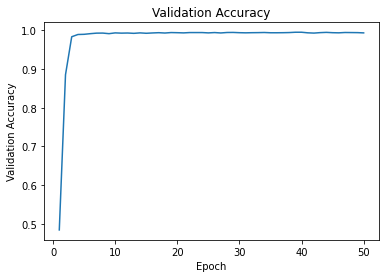

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.49625925925925923, 0.8892222222222222, 0.9864259259259259, 0.9923703703703703, 0.9947407407407407, 0.9962037037037037, 0.9972407407407408, 0.9981296296296296, 0.9983148148148148, 0.9988518518518519, 0.9989814814814815, 0.9990740740740741, 0.9991666666666666, 0.9992407407407408, 0.9992407407407408, 0.9993333333333333, 0.9994074074074074, 0.9994074074074074, 0.9994259259259259, 0.9994074074074074, 0.999462962962963, 0.999462962962963, 0.9995, 0.9995, 0.999537037037037, 0.999537037037037, 0.999537037037037, 0.9995555555555555, 0.9995555555555555, 0.9995555555555555, 0.9995555555555555, 0.9995555555555555, 0.9995555555555555, 0.9995925925925926, 0.9995925925925926, 0.9995925925925926, 0.9995925925925926, 0.9995925925925926, 0.9995925925925926, 0.9995740740740741, 0.9995925925925926, 0.9995925925925926, 0.9996111111111111, 0.9996296296296296, 0.9996296296296296, 0.9996111111111111, 0.9996296296296296, 0.9996296296296296, 0.9996296296296296, 0.9996296296296296]
val_accs = [0.4841666666666667, 0.8855, 0.9836666666666667, 0.9895, 0.99, 0.9916666666666667, 0.993, 0.9931666666666666, 0.9916666666666667, 0.9936666666666667, 0.993, 0.9933333333333333, 0.9925, 0.9936666666666667, 0.9926666666666667, 0.9935, 0.9941666666666666, 0.9933333333333333, 0.9945, 0.9941666666666666, 0.9936666666666667, 0.9945, 0.9945, 0.9945, 0.9936666666666667, 0.9945, 0.9935, 0.9946666666666667, 0.9948333333333333, 0.9941666666666666, 0.9938333333333333, 0.9941666666666666, 0.9943333333333333, 0.9946666666666667, 0.994, 0.994, 0.9941666666666666, 0.9945, 0.9953333333333333, 0.9953333333333333, 0.9938333333333333, 0.9931666666666666, 0.9943333333333333, 0.995, 0.9941666666666666, 0.9938333333333333, 0.9946666666666667, 0.9945, 0.9943333333333333, 0.9936666666666667]
epochs = [i for i in range(1,51)]

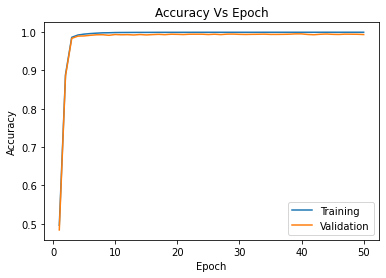

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.6684, Test Accuracy: 0.9950


Adam

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 5*1e-5
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.0823
Epoch [1/50], Step [20/53], Loss: 1.7980
Epoch [1/50], Step [30/53], Loss: 1.6935
Epoch [1/50], Step [40/53], Loss: 1.5787
Epoch [1/50], Step [50/53], Loss: 1.5626

Epoch [1/50]
 Train Loss: 83.0099, Train Accuracy: 0.8941
 Val Loss: 15.6572, Val Accuracy: 0.8950

Epoch [2/50], Step [10/53], Loss: 1.5653
Epoch [2/50], Step [20/53], Loss: 1.5072
Epoch [2/50], Step [30/53], Loss: 1.4767
Epoch [2/50], Step [40/53], Loss: 1.4771
Epoch [2/50], Step [50/53], Loss: 1.4743

Epoch [2/50]
 Train Loss: 78.0279, Train Accuracy: 0.9899
 Val Loss: 14.7478, Val Accuracy: 0.9877

Epoch [3/50], Step [10/53], Loss: 1.4706
Epoch [3/50], Step [20/53], Loss: 1.4733
Epoch [3/50], Step [30/53], Loss: 1.4698
Epoch [3/50], Step [40/53], Loss: 1.4690
Epoch [3/50], Step [50/53], Loss: 1.4673

Epoch [3/50]
 Train Loss: 77.8719, Train Accuracy: 0.9927
 Val Loss: 14.7326, Val Accuracy: 0.9886

Epoch [4/50], Step [10/53], Loss: 1.4675
Epoch [4/50], Step [20/53], Loss: 1.4711


In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[83.00992155075073, 78.02786445617676, 77.87186777591705, 77.75175774097443, 77.6736513376236, 77.64839911460876, 77.61450397968292, 77.63325262069702, 77.62801766395569, 77.6718682050705, 77.58624839782715, 77.54460501670837, 77.56123197078705, 77.54776501655579, 77.55264508724213, 77.58749341964722, 77.5328118801117, 77.55573916435242, 77.5051052570343, 77.53477728366852, 77.57228863239288, 77.58704173564911, 77.54440546035767, 77.51286244392395, 77.50938725471497, 77.50000810623169, 77.49756896495819, 77.5721904039383, 77.5600836277008, 77.53561675548553, 77.52863788604736, 77.53382503986359, 77.57622218132019, 77.54911661148071, 77.53520238399506, 77.52298653125763, 77.51796042919159, 77.5047777891159, 77.51367139816284, 77.5122127532959, 77.57057344913483, 77.54195988178253, 77.5516105890274, 77.51695561408997, 77.5042976140976, 77.49472391605377, 77.5103669166565, 77.56683909893036, 77.6480233669281, 77.52501320838928]

[0.8940925925925925, 0.9899444444444444, 0.9926666666666667,

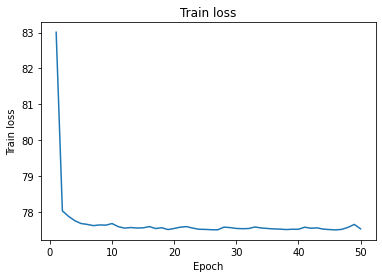

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

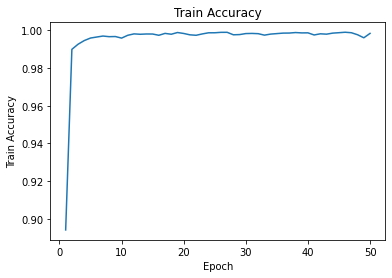

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

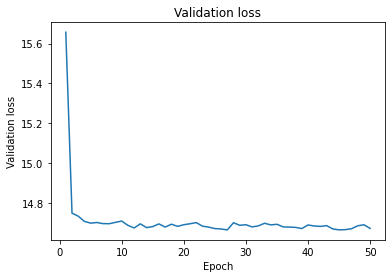

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

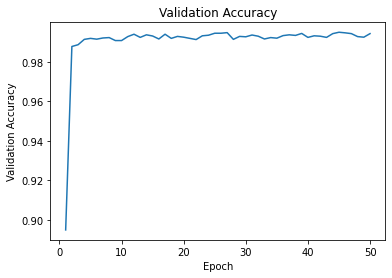

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.8940925925925925, 0.9899444444444444, 0.9926666666666667, 0.9946111111111111, 0.9959444444444444, 0.9964814814814815, 0.997, 0.9966666666666667, 0.9967407407407407, 0.9959074074074074, 0.9974074074074074, 0.9981481481481481, 0.9979444444444444, 0.9980925925925926, 0.9980740740740741, 0.9974074074074074, 0.9984074074074074, 0.9979629629629629, 0.9988703703703704, 0.9983703703703704, 0.9976481481481482, 0.9974074074074074, 0.9981296296296296, 0.9987222222222222, 0.9987407407407407, 0.9989629629629629, 0.9989814814814815, 0.9976666666666667, 0.9977777777777778, 0.9983148148148148, 0.9983888888888889, 0.9982592592592593, 0.9974814814814815, 0.9980370370370371, 0.9982962962962963, 0.9985555555555555, 0.9985925925925926, 0.9988518518518519, 0.9986666666666667, 0.9987037037037036, 0.9975740740740741, 0.9981851851851852, 0.998, 0.9985555555555555, 0.9987777777777778, 0.9990185185185185, 0.9987592592592592, 0.9976851851851852, 0.9960740740740741, 0.9984074074074074]
val_accs = [0.895, 0.9877, 0.9886, 0.9913, 0.9918, 0.9914, 0.992, 0.9922, 0.9907, 0.9907, 0.9927, 0.9939, 0.9923, 0.9936, 0.993, 0.9915, 0.9939, 0.9918, 0.9928, 0.9924, 0.9918, 0.9912, 0.9931, 0.9934, 0.9944, 0.9944, 0.9947, 0.9913, 0.9928, 0.9926, 0.9935, 0.9929, 0.9915, 0.9922, 0.9919, 0.9932, 0.9936, 0.9933, 0.9943, 0.9923, 0.9931, 0.9929, 0.9923, 0.9942, 0.9949, 0.9946, 0.9942, 0.9927, 0.9924, 0.9942]
epochs = [i for i in range(1,51)]

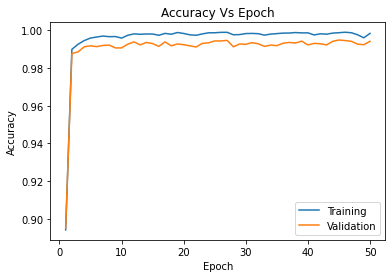

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.6683, Test Accuracy: 0.9946


RMS prop

In [ ]:
num_classes = 10
num_epochs = 50
learning_rate = 5*1e-5
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/50], Step [10/53], Loss: 2.0849
Epoch [1/50], Step [20/53], Loss: 1.9993
Epoch [1/50], Step [30/53], Loss: 1.7312
Epoch [1/50], Step [40/53], Loss: 1.5914
Epoch [1/50], Step [50/53], Loss: 1.5879

Epoch [1/50]
 Train Loss: 83.6944, Train Accuracy: 0.8831
 Val Loss: 15.7637, Val Accuracy: 0.8862

Epoch [2/50], Step [10/53], Loss: 1.5659
Epoch [2/50], Step [20/53], Loss: 1.5682
Epoch [2/50], Step [30/53], Loss: 1.5551
Epoch [2/50], Step [40/53], Loss: 1.5640
Epoch [2/50], Step [50/53], Loss: 1.4752

Epoch [2/50]
 Train Loss: 78.2527, Train Accuracy: 0.9860
 Val Loss: 14.7761, Val Accuracy: 0.9850

Epoch [3/50], Step [10/53], Loss: 1.4742
Epoch [3/50], Step [20/53], Loss: 1.4727
Epoch [3/50], Step [30/53], Loss: 1.4736
Epoch [3/50], Step [40/53], Loss: 1.4779
Epoch [3/50], Step [50/53], Loss: 1.4749

Epoch [3/50]
 Train Loss: 77.9196, Train Accuracy: 0.9917
 Val Loss: 14.7230, Val Accuracy: 0.9899

Epoch [4/50], Step [10/53], Loss: 1.4711
Epoch [4/50], Step [20/53], Loss: 1.4661


In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[83.69444024562836, 78.25274991989136, 77.91957950592041, 77.90952670574188, 77.81394350528717, 77.67946743965149, 77.64914202690125, 77.66268312931061, 77.82391691207886, 77.59670555591583, 77.7579255104065, 77.66187739372253, 77.65239596366882, 77.7641214132309, 77.64496171474457, 77.62668693065643, 77.59837985038757, 77.60748064517975, 77.88683235645294, 77.56861615180969, 77.55880200862885, 77.62825548648834, 77.66695439815521, 77.60771870613098, 77.5390123128891, 77.63711881637573, 77.72474801540375, 77.70940494537354, 77.5909606218338, 77.64410483837128, 77.79107081890106, 77.5758546590805, 77.6548718214035, 77.57389974594116, 77.56055045127869, 77.53859758377075, 77.59116995334625, 77.52140629291534, 77.56395947933197, 77.54766011238098, 77.58383393287659, 78.26947319507599, 77.57749438285828, 77.62453377246857, 77.62386429309845, 77.54698276519775, 77.56548273563385, 77.52153193950653, 77.97623884677887, 77.64056754112244]

[0.8831481481481481, 0.9859814814814815, 0.99170370370

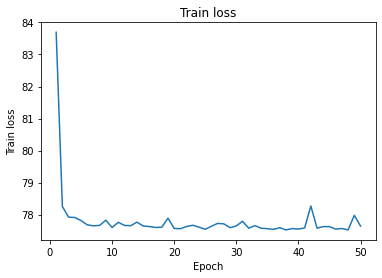

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

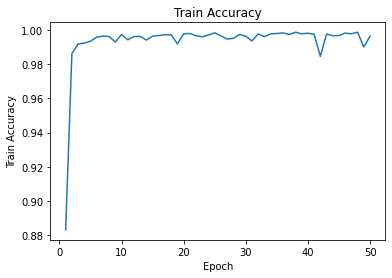

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

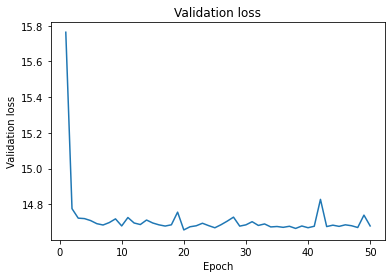

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

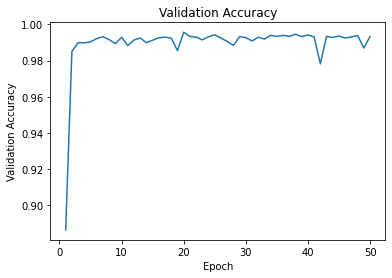

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
accs =[0.8831481481481481, 0.9859814814814815, 0.9917037037037038, 0.9921481481481481, 0.9932962962962963, 0.9956666666666667, 0.9962407407407408, 0.996037037037037, 0.9928148148148148, 0.9972407407407408, 0.9941111111111111, 0.996037037037037, 0.9960925925925926, 0.9939444444444444, 0.9962777777777778, 0.9965925925925926, 0.9970740740740741, 0.997, 0.9917222222222222, 0.9976481481481482, 0.9977777777777778, 0.9964814814814815, 0.9958518518518519, 0.9969629629629629, 0.9981666666666666, 0.9963888888888889, 0.994537037037037, 0.9949814814814815, 0.9971851851851852, 0.9962037037037037, 0.9934444444444445, 0.997537037037037, 0.9959074074074074, 0.997537037037037, 0.9977592592592592, 0.9981296296296296, 0.9972037037037037, 0.9985185185185185, 0.9976111111111111, 0.9979259259259259, 0.9972962962962963, 0.9844074074074074, 0.997462962962963, 0.9965, 0.9965555555555555, 0.9980185185185185, 0.9976111111111111, 0.9985185185185185, 0.9899259259259259, 0.9962037037037037]
val_accs = [0.8862, 0.985, 0.9899, 0.9898, 0.9904, 0.9922, 0.9932, 0.9916, 0.9894, 0.9929, 0.9883, 0.9914, 0.9925, 0.9899, 0.9913, 0.9926, 0.993, 0.9924, 0.9855, 0.9957, 0.9934, 0.993, 0.9915, 0.9932, 0.9943, 0.9925, 0.9906, 0.9884, 0.9933, 0.9927, 0.9909, 0.9929, 0.9919, 0.994, 0.9934, 0.994, 0.9934, 0.9946, 0.9933, 0.9942, 0.9931, 0.9782, 0.9934, 0.9928, 0.9936, 0.9925, 0.9931, 0.9939, 0.987, 0.9933]
epochs = [i for i in range(1,51)]

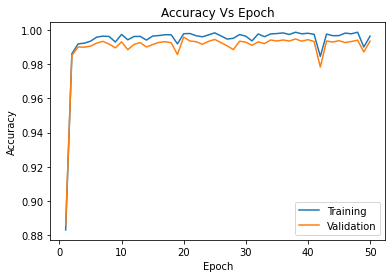

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 14.6810, Test Accuracy: 0.9931
